In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.colors import LogNorm
from numpy import pi, cos,sin
import os
import re
import sys

from astropy.io import fits
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.time import Time

from astroquery import sdss
from astroquery.simbad import Simbad 
from astroquery import sdss
from astroquery.skyview import SkyView



MODE=1 # only primary
# MODE=2 # only secondary

nano_maggies_to_Jy = 3631 * 10**-9 # constant of conversion
cspeedlight = 2.99792458e10
Jy_to_cgs = 1e-23

if not(os.path.isdir('figs')):
    os.makedirs('figs')
    

ra=Angle('0h8m05.63s',unit='hourangle').degree
dec=Angle('+14d50m23.3s',unit='hourangle').degree

In [57]:
name_input = "Mrk 422" # name of the object; if empty coordinates are used
ra_deg_input = ra  # ra in degree
dec_deg_input = dec # dec in degree
radius_input = 3.0 # arcmin
plotsky_flag= True
band='u' #  it can be 'u','g','r','i','z'
plotspectrum_flag=True
plottime_flag=True

In [58]:
# this is an example of logic to parse input parameters from name or coordinates
#name_input='Mrk5'

if name_input == "":
    ra_degree = ra_deg_input
    dec_degree = dec_deg_input
else:
    result_simbad = Simbad.query_object(name_input, wildcard=True)
    ra_unit = result_simbad['RA'].unit
    dec_unit = result_simbad['DEC'].unit
    ra_simbad = result_simbad['RA'].data[0]
    dec_simbad = result_simbad['DEC'].data[0]    
    def read_unit(un_in):
        if re.search('h:m:s', str(un_in)):
            un_out='hourangle'
        elif re.search('d:m:s', str(un_in)):
            un_out='degree'
        else:
            sys.exit('unit of RA = ' + str(ra_unit) + ' not implemented')
        return un_out
    
    ra_degree=Angle(ra_simbad,unit=read_unit(ra_unit)).degree
    dec_degree=Angle(dec_simbad,unit=read_unit(dec_unit)).degree


    
source = SkyCoord(ra_degree,dec_degree,unit='degree')
radius = Angle(radius_input, unit='arcmin')

photoobj_fields=['run', 'rerun','camcol','field','ra','dec','mode',
                    'psfFlux_u', 'psfFlux_g', 'psfFlux_r','psfFlux_i','psfFlux_z',
                    'psfFluxIvar_u','psfFluxIvar_g','psfFluxIvar_r','psfFluxIvar_i','psfFluxIvar_z',
                    'TAI_u', 'TAI_g', 'TAI_r', 'TAI_i', 'TAI_z','objID', 'thingId']

query1 = sdss.SDSS.query_region(source, radius=radius,data_release=16, 
                                photoobj_fields=photoobj_fields)

if query1 is not None:
    query={}
    for k in query1.keys():
        query[k]=query1[k].data
else:
    query=None

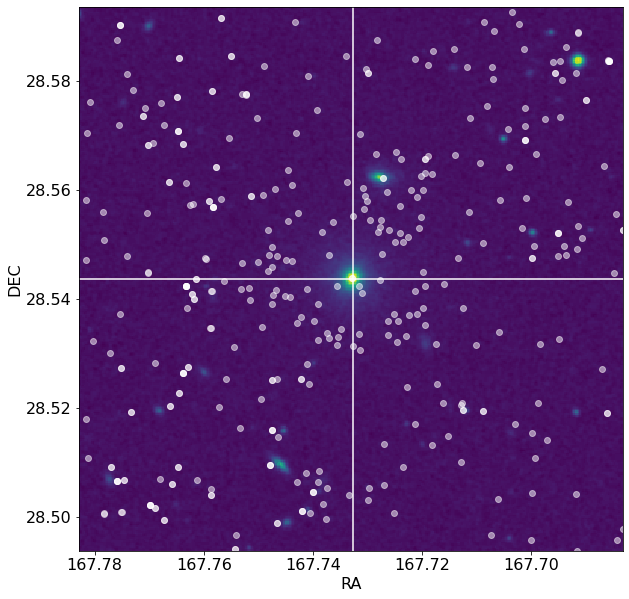

In [59]:
def show_image(qquery,ra_in, dec_in):

    npix=int(2*radius_input*60.) # if image is from SkyView service, pixels will be 1''
    npix=str(npix)+','+str(npix)

    pos_str = Angle(ra_degree,unit='degree').to_string(unit='hourangle') + ' ' + Angle(dec_degree,unit='degree').to_string(unit='degree')

    img = SkyView.get_images(position=pos_str,survey=['DSS2 Blue','DSS2 IR','DSS2 Red'],
                             pixels=npix,coordinates='J2000',grid=True,gridlabels=True)
    b = img[0][0]
    g = img[1][0]
    r = img[2][0]

    bi = (b.data)
    ri = (r.data)
    gi = (g.data)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(bi,interpolation='none',aspect='equal',extent=[b.header['CRVAL1']-(b.header['NAXIS1']-b.header['CRPIX1'])*b.header['CDELT1'],
                                                           b.header['CRVAL1']+(b.header['NAXIS1']-b.header['CRPIX1'])*b.header['CDELT1'],
                                                           b.header['CRVAL2']+(b.header['NAXIS2']-b.header['CRPIX2'])*b.header['CDELT2'],
                                                           b.header['CRVAL2']-(b.header['NAXIS2']-b.header['CRPIX2'])*b.header['CDELT2']])
    fig.gca().invert_yaxis()
    plt.axvline(ra_in,color='white')
    plt.axhline(dec_in,color='white')
    plt.scatter(qquery['ra'],qquery['dec'],color='white',alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.xlabel('RA',fontsize=16)
    plt.ylabel('DEC',fontsize=16)
    plt.savefig('figs/figure_sky.png')
    return

show_image(query, ra_degree, dec_degree)

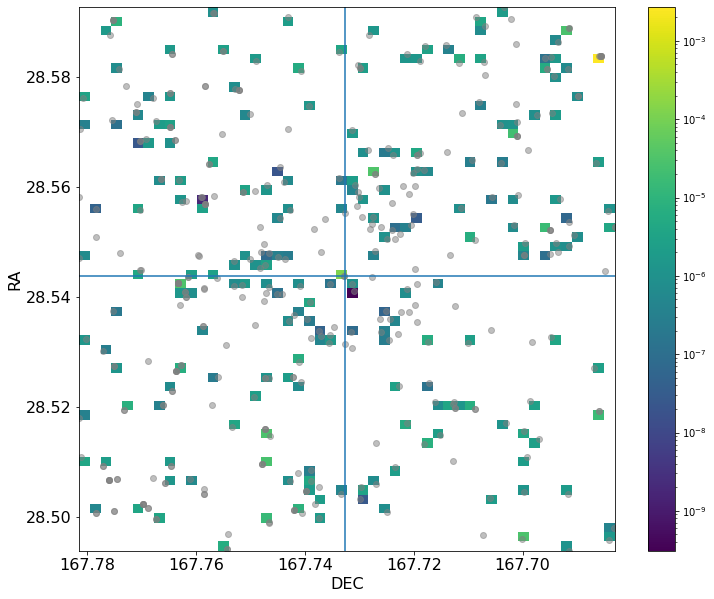

In [60]:
def pplot(qquery, ra_in, dec_in, primary=True):
    if qquery==None:
        return -1
    dec_min=min(qquery['dec'])
    dec_max=max(qquery['dec'])
    ra_min=min(qquery['ra'])
    ra_max=max(qquery['ra'])

    #pix_size = 1/60./10. # say, one arcmin
    pix_size=0.1
    #dec_mid  = (dec_min + dec_max) / 2.
    #Nra      = int((ra_max - ra_min) * cos(dec_mid * pi / 180.) / pix_size)
    #Ndec     = int((dec_max - dec_min) / pix_size)
    Nra      = int((ra_max-ra_min)*cos(dec_degree*pi/180.) / (pix_size/60.))
    Ndec     = int((dec_max-dec_min)/(pix_size/60.))

    ra_b     = np.linspace(ra_min, ra_max, Nra)
    dec_b    = np.linspace(dec_min, dec_max, Ndec)

    fig = plt.figure(figsize=(12,10))
    if primary:
        mode=np.where(qquery['mode']==1)[0]
    else:
        mode = np.range(len(qquery['mode']))
    plt.hist2d(qquery['ra'][mode], qquery['dec'][mode], bins=([ra_b, dec_b]), 
               weights=qquery['psfFlux_'+band][mode]*nano_maggies_to_Jy, 
              norm=LogNorm())
    plt.colorbar()
    plt.scatter(query['ra'],query['dec'],alpha=0.5,color='grey')
    plt.axhline(dec_in)# dec
    plt.axvline(ra_in)# ra
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.xlabel('DEC',fontsize=16)
    plt.ylabel('RA',fontsize=16)
    plt.gca().invert_xaxis()

    plt.savefig('figs/figure_sky.png')
    return 0

flag1=pplot(query, ra_degree, dec_degree)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


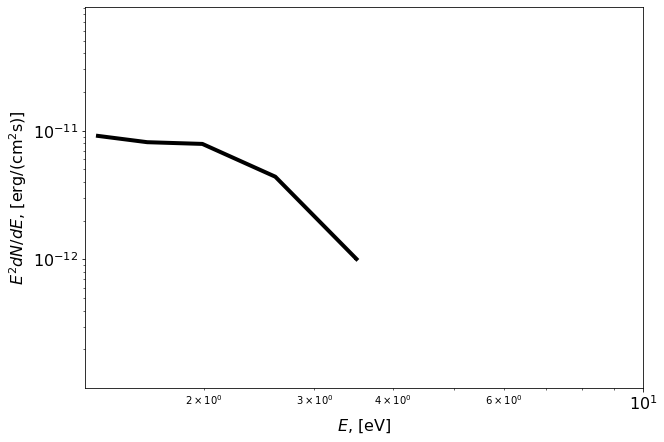

In [61]:
def plot_spectrum(qquery):
    if qquery==None:
        return -1
    filters={'u':3543, 'g':4770, 'r': 6231,'i':7625,'z':9134}


    # Wavelength (Angstroms)
    # Ultraviolet (u) 3543
    # Green (g) 4770
    # Red (r) 6231
    # Near Infrared (i) 7625
    # Infrared (z) 9134
    plt.figure(figsize=(10,7))

    #plt.figure(figsize=(10.*(1.+np.sqrt(5.)*0.5),10.))
    sep=np.array([])
    for i in range(len(qquery['run'])):
        rai    = qquery['ra'][i]
        deci   = qquery['dec'][i]
        coordi = SkyCoord(Angle(rai, unit='degree').degree, Angle(deci, unit='degree').degree, unit='deg')
        sep=np.append(sep,source.separation(coordi).arcmin)
    index=np.argmin(sep)
    label=['u','g','r','i','z']
    wavelength = np.array([filters[i] for i in label]) # in Angstroem
    wavelength = wavelength * 1e-8 # in cm
    frequency = cspeedlight / wavelength # in Hz
    energy = 4.1357e-15 * frequency # in eV
    #energy = 2.0 * np.pi * 6.67e-16 * frequency # in eV
    factor = Jy_to_cgs * frequency # conversion from Jy to erg/cm2s
    
    y1 = np.array([qquery['psfFlux_'+i][index] for i in label]) # in nanomaggies
    y1_err = np.array([1.0/np.sqrt(qquery['psfFluxIvar_'+i][index]) for i in label]) # in nanomaggies
    
    y = y1 * nano_maggies_to_Jy * factor # in erg/cm2s
    y_err = y1_err * nano_maggies_to_Jy*factor # in erc/cm2s

    plt.semilogy(energy, y)
    plt.errorbar(energy, y,y_err,color='black',linewidth=4)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    plt.xlabel('$E$, [eV]',fontsize=16)
    plt.ylabel('$E^2dN/dE$, [erg/(cm$^2$s)]',fontsize=16)

    #plt.xlabel('$\lambda[\AA]$',fontsize=16)
    #plt.ylabel('$flux[Jy]$',fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    xlim=plt.xlim()
    plt.xlim(10.0 * np.floor(xlim[0]/10),10.0*np.ceil(xlim[1]/10))
    plt.ylim(np.min(y)/10.,np.max(y)*10)

    plt.tick_params(axis='both', which='major', labelsize=16)

    plt.savefig("figs/figure_spectrum.png")
    return 0
flag2=plot_spectrum(query)

[53352.47590997]


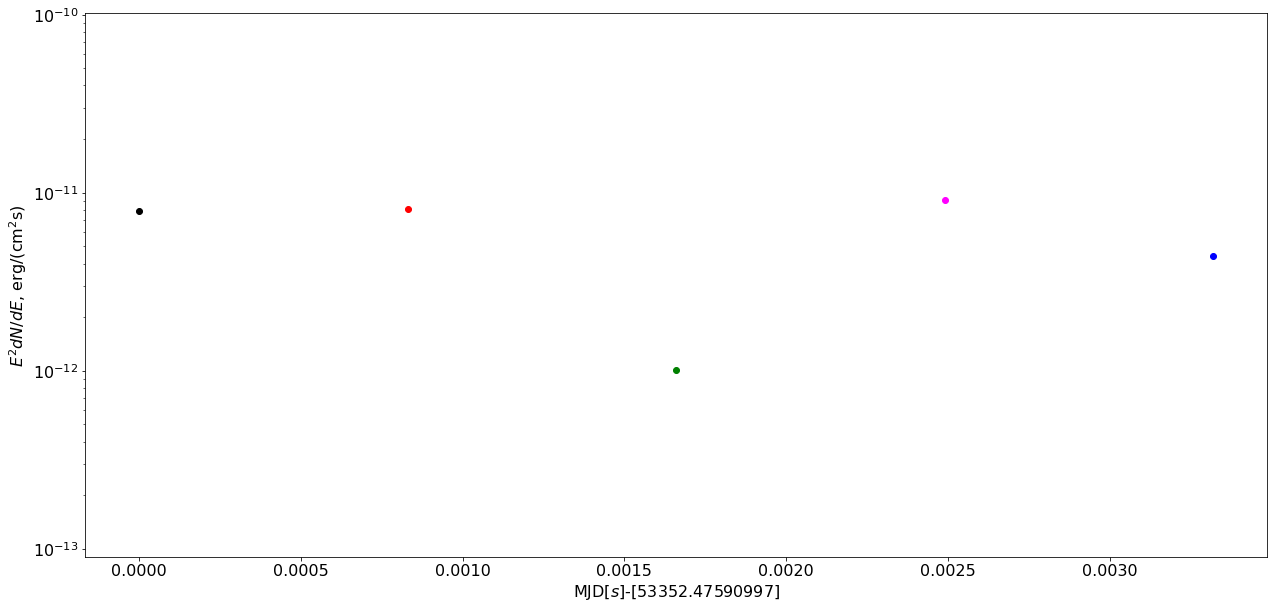

In [62]:
def plot_time(qquery):
    if qquery==None:
        return -1
    def MJD(t): # Modified Julian Date format
        return t/(24*3600)
    sep=np.array([])
    for i in range(len(qquery['ra'])):
        sep=np.append(sep,source.separation(SkyCoord(qquery['ra'][i],qquery['dec'][i], unit='deg')).deg)
    i_min=[np.argmin(sep),]

    thingid=query['thingId'][i_min]

    ilist=np.where((query['thingId']==thingid)&((query['mode']==1)|(query['mode']==2)))[0]
    i_mode1= np.where(query['mode'][ilist]==1)[0]

    #print(index)
    #print(query['mode'][index])
    
    plt.figure(figsize=(10.*(1.+np.sqrt(5.)*0.5),10.))
    label=['u','g','r','i','z']
    colors=['green', 'blue','black','red','magenta']
    filters={'u':3543, 'g':4770, 'r': 6231,'i':7625,'z':9134}
    wavelength = np.array([filters[key] for key in filters.keys()])# in Angstroem
    factor = Jy_to_cgs * cspeedlight / (wavelength * 1e-8) # converting factor for energy from Jy to erg/cm2s
    
    x = {}
    y = {}
    y_err = {}
    for ii in ilist:
        for j, lab in enumerate(label):
            if len(x)<5:
                x[lab] = np.array([qquery['TAI_'+lab][ii],])
                y[lab] = np.array([qquery['psfFlux_'+lab][ii],]) * nano_maggies_to_Jy * factor[j]
                y_err[lab] = np.array([1.0/np.sqrt(qquery['psfFluxIvar_'+lab][ii]),]) * nano_maggies_to_Jy * factor[j]
            else:
                x[lab] = np.concatenate([x[lab], [qquery['TAI_'+lab][ii],]])
                y[lab] = np.concatenate([y[lab], [qquery['psfFlux_'+lab][ii],]]) * nano_maggies_to_Jy * factor[j]
                y_err[lab] = np.array([1.0/np.sqrt(qquery['psfFluxIvar_'+lab][ii]),]) * nano_maggies_to_Jy * factor[j]
                
    t0=np.inf
    for i, lab in enumerate(label):
        t0 = min([x[lab],t0])
    t0=MJD(t0)
    print(t0)
    
    plt.semilogy([], [],data=None)
    for i,lab in enumerate(label):
        #t=Time(MJD(x[lab]), format='mjd'
        #t.format = 'iso'
        #t.out_subfmt = 'date_hms'
        t = MJD(x[lab])# modified julian date
        #plt.scatter(t.value, y[lab],color=colors[i])
        plt.scatter(t-t0, y[lab],color=colors[i])
        
    #plt.axvline(MJD(x[lab][i_mode1]))
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.xlabel('MJD'+'$[s]$' +'-'+str(t0),fontsize=16)
    plt.ylabel('$E^2dN/dE$, erg/(cm$^2$s)', fontsize=16)
    
    plt.yscale('log')
    ylim=plt.ylim()
    plt.ylim(ylim[0]/10.,ylim[1]*10)

    plt.savefig("figs/figure_time.png")
    return 0
flag3=plot_time(query)

In [63]:
image1_filename = "./figs/figure_sky.png"
message1 = 'Completed' if flag1==0 else 'Error'
image2_filename = "./figs/figure_spectrum.png"
message2 = 'Completed' if flag2==0 else 'Error'
image3_filename = "./figs/figure_time.png"
message3 = 'Completed' if flag3==0 else 'Error'